# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# Testing multilabel algorithms
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

### Referencias:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

El objetivo de este notebook es aplicar distintas técnicas de Aprendizaje Multietiqueta Tradicional (tanto de la familia de transformación del problema como de adaptación del algoritmo) para resolver el problema del etiquetado múltiple de patrones geométricos.

**Importante**: los métodos de transformación del algoritmo requieren de `scikit-multilearn` en su versión 0.2.0 y de `scikit-learn` en 0.24.1, lo cual solo es posible hasta Python 3.8. Por esta razón, se recomienda tener un ambiente especialmente diseñado para este notebook.

# Imports

In [1]:
root_dir='..'

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
import pickle

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Embedding classifiers (los dejamos afuera)
#from skmultilearn.embedding import OpenNetworkEmbedder, CLEMS, SKLearnEmbedder
#from sklearn.manifold import SpectralEmbedding
#from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
#from skmultilearn.embedding import EmbeddingClassifier
#from sklearn.ensemble import RandomForestRegressor

import random 


from utils import KunischMetrics
from utils import KunischPruner
from utils import DataExplorer
from utils import KunischPlotter

## Selección de dataset y modelos

In [2]:
# Flags para los datos sintéticos
# Cada flag está asociada a una o más funciones de data augmentation.
# Los datos deben existir previamente 
# (se generan a partir del notebook split and augmentation)
USE_RN50 = False
USE_WEIGHTS = True
ARCHITECTURE = 'resnet' 
DS_FLAGS = ['ref', 'rot', 'crop', 'rain', 'elastic', 'blur'] 
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
GAUSBLUR_TIMES = 1
NUM_LABELS = 107
K = 4

SAVE = True

In [3]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
         'gausblur': GAUSBLUR_TIMES
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = MAP_TIMES.keys()
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

Kfolds = {}

for i in range(0, K):
    print("Fold ", i)
    if ARCHITECTURE == 'resnet':
        patterns_dir = os.path.join(root_dir, 'patterns', data_flags, str(i))
        labels_dir = os.path.join(root_dir, 'labels', data_flags, str(i))
        exp_name = f'resnet50_K{i}' if USE_RN50 else f'resnet18_K{i}'
        rn = 50 if USE_RN50 else 18
        features_dir = os.path.join(root_dir, 'features', ARCHITECTURE, data_flags, exp_name)
    
    else:
        patterns_dir = os.path.join(root_dir, 'patterns', data_flags, str(i))
        labels_dir = os.path.join(root_dir, 'labels', data_flags, str(i))
        exp_name = f'K{i}'
        features_dir = os.path.join(root_dir, 'features', ARCHITECTURE, data_flags, exp_name)
    
    if not (os.path.isdir(patterns_dir) and os.path.isdir(labels_dir)):
        print(patterns_dir)
        print(labels_dir)
        raise FileNotFoundError("""
        No existen directorios de datos para el conjunto de flags seleccionado. 
        Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation.
        """)
    if not (os.path.isdir(features_dir)):
        print(features_dir)
        raise FileNotFoundError(f"""
        No se encontraron features para el conjunto de flags seleccionado. 
        Verifique que existan y, de lo contrario, llame a Feature Extraction
        """)
                                
    Kfolds[i] = {
        'patterns_dir': patterns_dir,
        'labels_dir': labels_dir,
        'features_dir': features_dir
    }
    
    print("--Pattern set encontrado en {}".format(patterns_dir))
    print("--Labels set encontrado en {}".format(labels_dir))
    print("--Features set encontrado en {}".format(features_dir))
    print("")

#../features/resnet/resnet50_base/
#../labels/base/
#Features set encontrado en ../features/resnet/resnet50_base/
#Labels set encontrado en ../labels/base/

Fold  0
--Pattern set encontrado en ..\patterns\blur_rain_ref_rot_crop1_elastic1\0
--Labels set encontrado en ..\labels\blur_rain_ref_rot_crop1_elastic1\0
--Features set encontrado en ..\features\resnet\blur_rain_ref_rot_crop1_elastic1\resnet18_K0

Fold  1
--Pattern set encontrado en ..\patterns\blur_rain_ref_rot_crop1_elastic1\1
--Labels set encontrado en ..\labels\blur_rain_ref_rot_crop1_elastic1\1
--Features set encontrado en ..\features\resnet\blur_rain_ref_rot_crop1_elastic1\resnet18_K1

Fold  2
--Pattern set encontrado en ..\patterns\blur_rain_ref_rot_crop1_elastic1\2
--Labels set encontrado en ..\labels\blur_rain_ref_rot_crop1_elastic1\2
--Features set encontrado en ..\features\resnet\blur_rain_ref_rot_crop1_elastic1\resnet18_K2

Fold  3
--Pattern set encontrado en ..\patterns\blur_rain_ref_rot_crop1_elastic1\3
--Labels set encontrado en ..\labels\blur_rain_ref_rot_crop1_elastic1\3
--Features set encontrado en ..\features\resnet\blur_rain_ref_rot_crop1_elastic1\resnet18_K3



# Data exploration

In [4]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

In [6]:
print("Iniciando revisión de datasets")
for i in range(0, K):
    fold = Kfolds[i]
    print("Fold ", i)
    features_dir = fold['features_dir']
    labels_dir = fold['labels_dir']

    features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
    features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
    features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')

    assert features_train.shape[1] == features_test.shape[1] == features_val.shape[1]
    assert features_test.shape[0] == 194
    assert features_val.shape[0] == 78
    print(f"--Utilizando descriptores de dimensión {features_train.shape[1]}")

    labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
    labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
    labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

    assert labels_train.shape[1] == labels_test.shape[1] == labels_val.shape[1]
    #assert labels_test.shape[0] == 194
    #assert labels_val.shape[0] == 78
    print(f"--Los archivos de etiquetas contienen {labels_train.shape[1]} etiquetas distintas.")
    print("Fold aprobado.")
    print()

Iniciando revisión de datasets
Fold  0
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  1
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  2
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.

Fold  3
--Utilizando descriptores de dimensión 512
--Los archivos de etiquetas contienen 330 etiquetas distintas.
Fold aprobado.



In [7]:
k = 0 # cambiar para explorar otros folds
print(f"Explorando fold {k}")
fold = Kfolds[k]
labels_dir = fold['labels_dir']
labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

train_columns = labels_train.columns.values
labels_75f = labels_train.loc[['75f']].values
print('Etiquetas 75f: ' + ''.join(np.where(labels_75f == 1, train_columns, '')[0]))

explorer = DataExplorer(labels_train, labels_val, labels_test)
combinations = explorer.get_unique_combinations(study='all')
metrics = explorer.get_label_metrics(study='all')

Explorando fold 0
Etiquetas 75f: horizontalpanelconcentriccircle
Number of unique labels combinations in all: 587
Label cardinality in all: 5.257870753935259
Label density in all: 0.015932941678591692


In [8]:
pruner = KunischPruner(NUM_LABELS)
print("Comenzando con i={}".format(NUM_LABELS))

# Carga o generacion de top labels
top_labels = None
if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle')):
    save = input(f"Se creará un archivo nuevo para {NUM_LABELS} labels con el fold 0. Desea continuar? (y/n)")
    if save == "y":
        labels_dir = Kfolds[0]['labels_dir']
        train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')
        top_labels = pruner.filter_labels(train_labels)
        with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'wb') as f:
            pickle.dump(top_labels, f)
        print("Top labels creado con éxito")
    else:
        raise Exception("No se logró cargar top_labels")
else:
    print(f"Usando top_labels previamente generados para {NUM_LABELS} labels")
    with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'rb') as f:
        top_labels = pickle.load(f)
    print(f"top labels previamente generado contiene {len(top_labels)} etiquetas")

pruner.set_top_labels(top_labels)

labels_train = pruner.filter_df(labels_train)
labels_val = pruner.filter_df(labels_val)
labels_test = pruner.filter_df(labels_test)
df = pd.concat([labels_train, labels_val, labels_test])

n = 4
#print(np.where((df.sum(axis=0) >= n)))
patrones = df.shape[0]
patrones_con_etiqueta = len(np.where((df.sum(axis=1) >= n))[0])
#print(np.where((df.sum(axis=1) >= n)))
print(patrones)
print(patrones_con_etiqueta)
print(patrones_con_etiqueta/patrones*100)
df = df.loc[df.sum(axis=1) >= n]

Comenzando con i=107
Usando top_labels previamente generados para 107 labels
top labels previamente generado contiene 107 etiquetas
4828
3803
78.76967688483845


In [9]:
explorer = DataExplorer(labels_train, labels_val, labels_test)
combinations = explorer.get_unique_combinations(study='all')
metrics = explorer.get_label_metrics(study='all')
print()
print("Mostrando ahora resultados para original df")
labels_original = pd.read_json("../labels/original_df.json", orient='index')
explorer = DataExplorer(labels_original, labels_original, labels_original)
combinations = explorer.get_unique_combinations(study='all')
metrics = explorer.get_label_metrics(study='all')

Number of unique labels combinations in all: 545
Label cardinality in all: 4.737158243579006
Label density in all: 0.0442725069493365

Mostrando ahora resultados para original df
Number of unique labels combinations in all: 596
Label cardinality in all: 3.030927835051536
Label density in all: 0.005172231800429242


# Funciones auxiliares

In [10]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    return clf_predictions

def show_predictions(ypred, ytrue, n=157):
    index = ytrue.index
    labels = ytrue.columns
    ytrue = ytrue.values
    labval = labels.values
    passed = []
    for i in range(150, n):
        rdm = random.randint(0, n)
        while rdm in passed:
            rdm = random.randint(0, n)
        passed.append(rdm)
        yp = np.where(ypred[rdm])
        yt = np.where(ytrue[rdm])
        etiquetas_pred = ' '.join(labval[j] for j in yp[1])
        etiquetas_true = ' '.join(labval[j] for j in yt[0])
        print("Patron: ", index[rdm])
        print("Etiquetas reales: ", etiquetas_true)
        print("Etiquetas predichas: ", etiquetas_pred)
        print("")

## Búsqueda de parámetros con Grid CV

#### MLTSVM

In [ ]:
#myclf = MLTSVM()

features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')


labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

X_train = features_train.sort_index()
X_test = features_test.sort_index()

Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
Y_test = pruner.filter_df(labels_test) # in both train and test

xtrain = X_train
xtest = X_test
ytrain = Y_train
ytest = Y_test

xtrain = sparse.csr_matrix(xtrain)
ytrain = sparse.csr_matrix(ytrain)
xtest = sparse.csr_matrix(xtest)
ytest = sparse.csr_matrix(ytest)
            
#myclf.fit(xtrain, ytrain)
#clf_predictions = myclf.predict(xtest)
#print(clf_predictions)

In [ ]:
from skmultilearn.adapt import MLTSVM
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

parameters = {'c_k': [1, 2],
              'sor_omega':[1.0, 1.5],
              'threshold':[0.00001, 0.00005],
              'lambda_param':[1.0, 1.5], 
              'max_iteration':[200, 500]}

score = 'f1_micro'

cv1 = GridSearchCV(MLTSVM(), parameters, scoring=score, verbose=3, n_jobs = -1, error_score='raise')

In [ ]:
cv1.fit(sparse.csr_matrix(X_train), sparse.csr_matrix(Y_train))
            
print (cv1.best_params_, cv1.best_score_)

#### MLkNN

In [ ]:
parameters = {'k': [1, 2, 4, 8],
              's':[0.5, 1.0, 1.5],
              'ignore_first_neighbours':[0, 1, 2, 4]}
score = 'f1_micro'

cv2 = GridSearchCV(MLkNN(), parameters, scoring=score, verbose=3, n_jobs = -1, error_score='raise')

In [ ]:
cv2.fit(sparse.csr_matrix(features_train.sort_index()), sparse.csr_matrix(labels_train.sort_index()))

print (cv2.best_params_, cv2.best_score_)

#### BRkNN

In [ ]:
parameters = {'k': [1, 2, 4, 8, 16, 32, 64, 128]}
score = 'f1_micro'

cv3 = GridSearchCV(BRkNNaClassifier(), parameters, scoring=score, verbose=3, n_jobs = -1, error_score='raise')

In [ ]:
cv3.fit(sparse.csr_matrix(features_train.sort_index()), sparse.csr_matrix(labels_train.sort_index()))

print (cv3.best_params_, cv3.best_score_)

# Benchmark


In [11]:
TRANSF_METHODS = {"BR": BinaryRelevance}
TRANSF_METHODS = {"BR": BinaryRelevance, "CC": ClassifierChain,
                 "LP": LabelPowerset, "RakelD": RakelD}

mlknn = MLkNN(ignore_first_neighbours= 0, k= 4, s= 1.0)
mltsvm = MLTSVM(c_k= 2, lambda_param= 1.0, max_iteration= 200, sor_omega= 1.0, threshold= 1e-05)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {}
#ADAPT_METHODS = {"MLkNN": mlknn, "MLTSVM": mltsvm, "BRkNN": brknna}

if USE_WEIGHTS:
    print("Usando balanced weights")
    BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs', class_weight='balanced'),
                        "SVM": svm.SVC(class_weight='balanced'),
                        "DT": tree.DecisionTreeClassifier(class_weight='balanced'),
                        # GNB no admite pesos
                       }
else:
    print("No se usarán pesos en este entrenamiento")
    BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                        "SVM": svm.SVC(),
                        "DT": tree.DecisionTreeClassifier(),
                        "GNB": GaussianNB(),
                       }

Usando balanced weights


In [105]:
LABELS_IN_STUDY = [5, 14, 26, 34, 54, 63] #72, 82, 91, 107, 131, 169, 281]
#for i in range(26, 300, 10):
#    LABELS_IN_STUDY.append(i)

exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}
exp_f1 = {}
exp_f2 = {}
exp_precision = {}
exp_recall = {}
exp_acc = {}
exp_1mr = {}
exp_2mr = {}
exp_3mr = {}
exp_4mr = {}
exp_5mr = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss[meth_name + "_" + base_name] = []
    exp_f1[meth_name + "_" + base_name] = []
    exp_f2[meth_name + "_" + base_name] = []
    exp_precision[meth_name + "_" + base_name] = []
    exp_recall[meth_name + "_" + base_name] = []
    exp_acc[meth_name + "_" + base_name] = []
    exp_1mr[meth_name + "_" + base_name] = []
    exp_2mr[meth_name + "_" + base_name] = []
    exp_3mr[meth_name + "_" + base_name] = []
    exp_4mr[meth_name + "_" + base_name] = []
    exp_5mr[meth_name + "_" + base_name] = []

for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss[meth_name] = []
  exp_f1[meth_name] = []
  exp_f2[meth_name] = []
  exp_precision[meth_name] = []
  exp_recall[meth_name] = []
  exp_acc[meth_name] = []
  exp_1mr[meth_name] = []
  exp_2mr[meth_name] = []
  exp_3mr[meth_name] = []
  exp_4mr[meth_name] = []
  exp_5mr[meth_name] = []

PREVIOUS_LABELS = 0
USED_FREQS = []

output_dir = os.path.join(root_dir, 'outputs', ARCHITECTURE,
                           data_flags, f'{min(LABELS_IN_STUDY)}-{max(LABELS_IN_STUDY)}L')

print("Output dir: ", output_dir)
os.makedirs(output_dir, exist_ok = True)

for i in LABELS_IN_STUDY:
  pruner = KunischPruner(i)
  print("Comenzando con i={}".format(i))
    
  # Carga o generacion de top labels
  top_labels = None
  if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{i}L.pickle')):
        save = input(f"Se creará un archivo nuevo para {i} labels con el fold 0. Desea continuar? (y/n)")
        if save == "y":
            labels_dir = Kfolds[0]['labels_dir']
            train_labels = pd.read_json(os.path.join(labels_dir, 'augmented_train_df.json'), orient='index')
            top_labels = pruner.filter_labels(train_labels)
            with open(os.path.join(root_dir, 'labels', f'top_{i}L.pickle'), 'wb') as f:
                pickle.dump(top_labels, f)
            print("Top labels creado con éxito")
        else:
            raise Exception("No se logró cargar top_labels")
  else:
        print(f"Usando top_labels previamente generados para {i} labels")
        with open(os.path.join(root_dir, 'labels', f'top_{i}L.pickle'), 'rb') as f:
            top_labels = pickle.load(f)
        print(f"top labels previamente generado contiene {len(top_labels)} etiquetas")
  
  pruner.set_top_labels(top_labels)
        
  if len(top_labels) == PREVIOUS_LABELS:
        print(f"Al intentar usar {i} labels, se repitió el valor previo {PREVIOUS_LABELS}. Saltando iteración.")
        continue
        
  PREVIOUS_LABELS = len(top_labels)
  USED_FREQS.append(i)
  

  for meth_name, method in ADAPT_METHODS.items():
        print("-Probando suerte con", meth_name)

        sum_f1 = 0
        sum_f2 = 0
        sum_recall = 0
        sum_precision = 0
        sum_acc = 0
        sum_hl = 0
        sum_emr = 0
        sum_hs = 0
        
        sum_mr1 = 0
        sum_mr2 = 0
        sum_mr3 = 0
        sum_mr4 = 0
        sum_mr5 = 0

        # Iterate over folds
        for j in range(0, K):
            #print(f"--Trabajando fold {j}")
            fold = Kfolds[j]
            features_dir = fold['features_dir']
            labels_dir = fold['labels_dir']
            
            features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
            features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
            features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
            
            labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
            labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
            labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')
            
            #features_test = pd.concat([features_val, features_test])
            #labels_test = pd.concat([labels_val, labels_test])
            
            # Dataset creation
            
            X_train = features_train.sort_index()
            X_test = features_test.sort_index()
            
            Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
            Y_test = pruner.filter_df(labels_test) # in both train and test

            Y_train = Y_train.sort_index()
            Y_test = Y_test.sort_index()

            assert X_train.index.all() == Y_train.index.all()
            assert X_test.index.all() == Y_test.index.all()              
            
            predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
            metrics = KunischMetrics(Y_test.values, predictions_i)
            
            micro_f1 = metrics.f1(average='micro')
            micro_f2 = metrics.f2(average='micro')
            micro_recall = metrics.recall(average='micro')
            micro_precision = metrics.precision(average='micro')
            acc = metrics.acc()
            hl = metrics.hl()
            emr = metrics.emr()
            hs = metrics.hs()
            
            mr1 = metrics.mr1()
            mr2 = metrics.mr2()
            mr3 = metrics.mr3()
            mr4 = metrics.mr4()
            mr5 = metrics.mr5()

            #print("---Micro F1:", micro_f1)
            #print("---Micro recall:", micro_recall)
            #print("---Micro precision:", micro_precision)
            #print("---Accuracy:", acc)
            #print("---Hamming Loss:", hl)
            #print("---Exact Match Ratio:", emr)
            #print("---Hamming Score:", hs)
            #print("---5-Match Ratio:", mr5)

            sum_f1 += micro_f1
            sum_f2 += micro_f2
            sum_recall += micro_recall
            sum_precision += micro_precision
            sum_acc += acc
            sum_hl += hl 
            sum_emr += emr
            sum_hs += hs
            
            sum_mr1 += mr1
            sum_mr2 += mr2
            sum_mr3 += mr3
            sum_mr4 += mr4
            sum_mr5 += mr5
            #print("")

        avg_f1 = round(sum_f1/K, 4)
        avg_f2 = round(sum_f2/K, 4)
        avg_recall = round(sum_recall/K, 4)
        avg_precision = round(sum_precision/K, 4)
        avg_acc = round(sum_acc/K, 4)
        avg_hl = round(sum_hl/K, 4)
        avg_emr = round(sum_emr/K, 4)
        avg_hs = round(sum_hs/K, 4)
        
        avg_mr1 = round(sum_mr1/K, 4)
        avg_mr2 = round(sum_mr2/K, 4)
        avg_mr3 = round(sum_mr3/K, 4)
        avg_mr4 = round(sum_mr4/K, 4)
        avg_mr5 = round(sum_mr5/K, 4)
        
        print("---AVG Micro F1:", avg_f1)
        print("---AVG Micro F2:", avg_f2)
        print("---AVG Micro recall:", avg_recall)
        print("---AVG Micro precision:", avg_precision)
        print("---AVG Accuracy:", avg_acc)
        print("---AVG Hamming Loss:", avg_hl)
        print("---AVG Exact Match Ratio:", avg_emr)
        print("---AVG Hamming Score:", avg_hs)
        print("---AVG 1-Match Ratio:", avg_mr1)
        print("---AVG 2-Match Ratio:", avg_mr2)
        print("---AVG 3-Match Ratio:", avg_mr3)
        print("---AVG 4-Match Ratio:", avg_mr4)
        print("---AVG 5-Match Ratio:", avg_mr5)
            
        exp_exact_match[meth_name].append(avg_emr)
        exp_hscore[meth_name].append(avg_hs)
        exp_hloss[meth_name].append(avg_hl)
        exp_precision[meth_name].append(avg_precision)
        exp_recall[meth_name].append(avg_recall)
        exp_f1[meth_name].append(avg_f1)
        exp_f2[meth_name].append(avg_f2)
        exp_acc[meth_name].append(avg_acc)
        
        exp_1mr[meth_name].append(avg_mr1)
        exp_2mr[meth_name].append(avg_mr2)
        exp_3mr[meth_name].append(avg_mr3)
        exp_4mr[meth_name].append(avg_mr4)
        exp_5mr[meth_name].append(avg_mr5)
        
        print("")
        
  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
        for base_name, classifier in BASE_CLASSIFIERS.items():
            print("-Probando suerte con", meth_name, base_name)

            sum_f1 = 0
            sum_f2 = 0
            sum_recall = 0
            sum_precision = 0
            sum_acc = 0
            sum_hl = 0
            sum_emr = 0
            sum_hs = 0
            
            sum_mr1 = 0
            sum_mr2 = 0
            sum_mr3 = 0
            sum_mr4 = 0
            sum_mr5 = 0
            
            used_folds = 0
            # Iterate over folds
            for j in range(0, K):
                #print(f"--Trabajando fold {i}")
                fold = Kfolds[j]
                features_dir = fold['features_dir']
                labels_dir = fold['labels_dir']
                features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
                features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
                features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
                labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
                labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
                labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')
                
                # Dataset creation
                X_train = features_train.sort_index()
                X_test = features_test.sort_index()
                
                Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
                Y_test = pruner.filter_df(labels_test) # in both train and test
                
                Y_train = Y_train.sort_index()
                Y_test = Y_test.sort_index()
                
                assert X_train.index.all() == Y_train.index.all()
                assert X_test.index.all() == Y_test.index.all()
                
                try:
                    predictions_i = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
                    used_folds += 1
                except:
                    print("Error por clase no presente en entrenamiento/test, saltando fold")
                    continue
                metrics = KunischMetrics(Y_test.values, predictions_i)

                micro_f1 = metrics.f1(average='micro')
                micro_f2 = metrics.f2(average='micro')
                micro_recall = metrics.recall(average='micro')
                micro_precision = metrics.precision(average='micro')
                acc = metrics.acc()
                hl = metrics.hl()
                emr = metrics.emr()
                hs = metrics.hs()
                
                mr1 = metrics.mr1()
                mr2 = metrics.mr2()
                mr3 = metrics.mr3()
                mr4 = metrics.mr4()
                mr5 = metrics.mr5()
                #print("---Micro F1:", micro_f1)
                #print("---Micro F2:", micro_f2)
                #print("---Micro recall:", micro_recall)
                #print("---Micro precision:", micro_precision)
                #print("---Accuracy:", acc)
                #print("---Hamming Loss:", hl)
                #print("---Exact Match Ratio:", emr)
                #print("---Hamming Score:", hs)
                #print("---5-Match Ratio:", mr5)

                sum_f1 += micro_f1
                sum_f2 += micro_f2
                sum_recall += micro_recall
                sum_precision += micro_precision
                sum_acc += acc
                sum_hl += hl 
                sum_emr += emr
                sum_hs += hs
                sum_mr1 += mr1
                sum_mr2 += mr2
                sum_mr3 += mr3
                sum_mr4 += mr4
                sum_mr5 += mr5
                #print("")

            avg_f1 = round(sum_f1/used_folds, 4)
            avg_f2 = round(sum_f2/used_folds, 4)
            avg_recall = round(sum_recall/used_folds, 4)
            avg_precision = round(sum_precision/used_folds, 4)
            avg_acc = round(sum_acc/used_folds, 4)
            avg_hl = round(sum_hl/used_folds, 4)
            avg_emr = round(sum_emr/used_folds, 4)
            avg_hs = round(sum_hs/used_folds, 4)
            
            avg_mr1 = round(sum_mr1/used_folds, 4)
            avg_mr2 = round(sum_mr2/used_folds, 4)
            avg_mr3 = round(sum_mr3/used_folds, 4)
            avg_mr4 = round(sum_mr4/used_folds, 4)
            avg_mr5 = round(sum_mr5/used_folds, 4)

            print("---AVG Micro F1:", avg_f1)
            print("---AVG Micro F2:", avg_f2)
            print("---AVG Micro recall:", avg_recall)
            print("---AVG Micro precision:", avg_precision)
            print("---AVG Accuracy:", avg_acc)
            print("---AVG Hamming Loss:", avg_hl)
            print("---AVG Exact Match Ratio:", avg_emr)
            print("---AVG Hamming Score:", avg_hs)
            print("---AVG 1-Match Ratio:", avg_mr1)
            print("---AVG 2-Match Ratio:", avg_mr2)
            print("---AVG 3-Match Ratio:", avg_mr3)
            print("---AVG 4-Match Ratio:", avg_mr4)
            print("---AVG 5-Match Ratio:", avg_mr5)

            exp_exact_match[meth_name + "_" + base_name].append(avg_emr)
            exp_hscore[meth_name + "_" + base_name].append(avg_hs)
            exp_hloss[meth_name + "_" + base_name].append(avg_hl)
            exp_precision[meth_name + "_" + base_name].append(avg_precision)
            exp_recall[meth_name + "_" + base_name].append(avg_recall)
            exp_f1[meth_name + "_" + base_name].append(avg_f1)
            exp_f2[meth_name + "_" + base_name].append(avg_f2)
            exp_acc[meth_name + "_" + base_name].append(avg_acc)
            exp_1mr[meth_name + "_" + base_name].append(avg_mr1)
            exp_2mr[meth_name + "_" + base_name].append(avg_mr2)
            exp_3mr[meth_name + "_" + base_name].append(avg_mr3)
            exp_4mr[meth_name + "_" + base_name].append(avg_mr4)
            exp_5mr[meth_name + "_" + base_name].append(avg_mr5)
            print("")


Output dir:  ..\outputs\resnet\testlocooooo\blur_rain_ref_rot_crop1_elastic1\281-281L
Comenzando con i=281
Usando top_labels previamente generados para 281 labels
top labels previamente generado contiene 281 etiquetas
-Probando suerte con BR LR
Error por clase no presente en entrenamiento/test, saltando fold
Error por clase no presente en entrenamiento/test, saltando fold
Error por clase no presente en entrenamiento/test, saltando fold
---AVG Micro F1: 0.435
---AVG Micro F2: 0.5448
---AVG Micro recall: 0.6551
---AVG Micro precision: 0.3256
---AVG Accuracy: 0.0155
---AVG Hamming Loss: 0.0314
---AVG Exact Match Ratio: 0.0155
---AVG Hamming Score: 0.0027
---AVG 1-Match Ratio: 0.9691
---AVG 2-Match Ratio: 0.9072
---AVG 3-Match Ratio: 0.7113
---AVG 4-Match Ratio: 0.5103
---AVG 5-Match Ratio: 0.3454



In [106]:
df_output = None
for i, labels in enumerate(LABELS_IN_STUDY):
    df_tmp = {}
    for meth_name in exp_exact_match.keys():
        meth_results = {
            'labels': labels,
            'accuracy': exp_acc[meth_name][i],
            'hamming_score': exp_hscore[meth_name][i],
            'hamming_loss': exp_hloss[meth_name][i],
            'f1_score': exp_f1[meth_name][i],
            'f2_score': exp_f2[meth_name][i],
            'recall': exp_recall[meth_name][i],
            'precision': exp_precision[meth_name][i],
            'emr': exp_exact_match[meth_name][i],
            '1mr': exp_1mr[meth_name][i],
            '2mr': exp_2mr[meth_name][i],
            '3mr': exp_3mr[meth_name][i],
            '4mr': exp_4mr[meth_name][i],
            '5mr': exp_5mr[meth_name][i],
        }
        df_tmp[meth_name] = meth_results
    if df_output is None:
        df_output = pd.DataFrame.from_dict(df_tmp, orient='index')
    else:
        df_tmp = pd.DataFrame.from_dict(df_tmp, orient='index')
        df_output = pd.concat([df_output, df_tmp])
if SAVE:         
    os.makedirs(output_dir, exist_ok=True)
    display(df_output)
    df_output.to_csv(os.path.join(output_dir, 'resultados.csv'))

labels  accuracy  hamming_score  hamming_loss  f1_score  f2_score  \
BR_LR     107    0.0155         0.0027        0.0314     0.435    0.5448   

       recall  precision     emr     1mr     2mr     3mr     4mr     5mr  
BR_LR  0.6551     0.3256  0.0155  0.9691  0.9072  0.7113  0.5103  0.3454

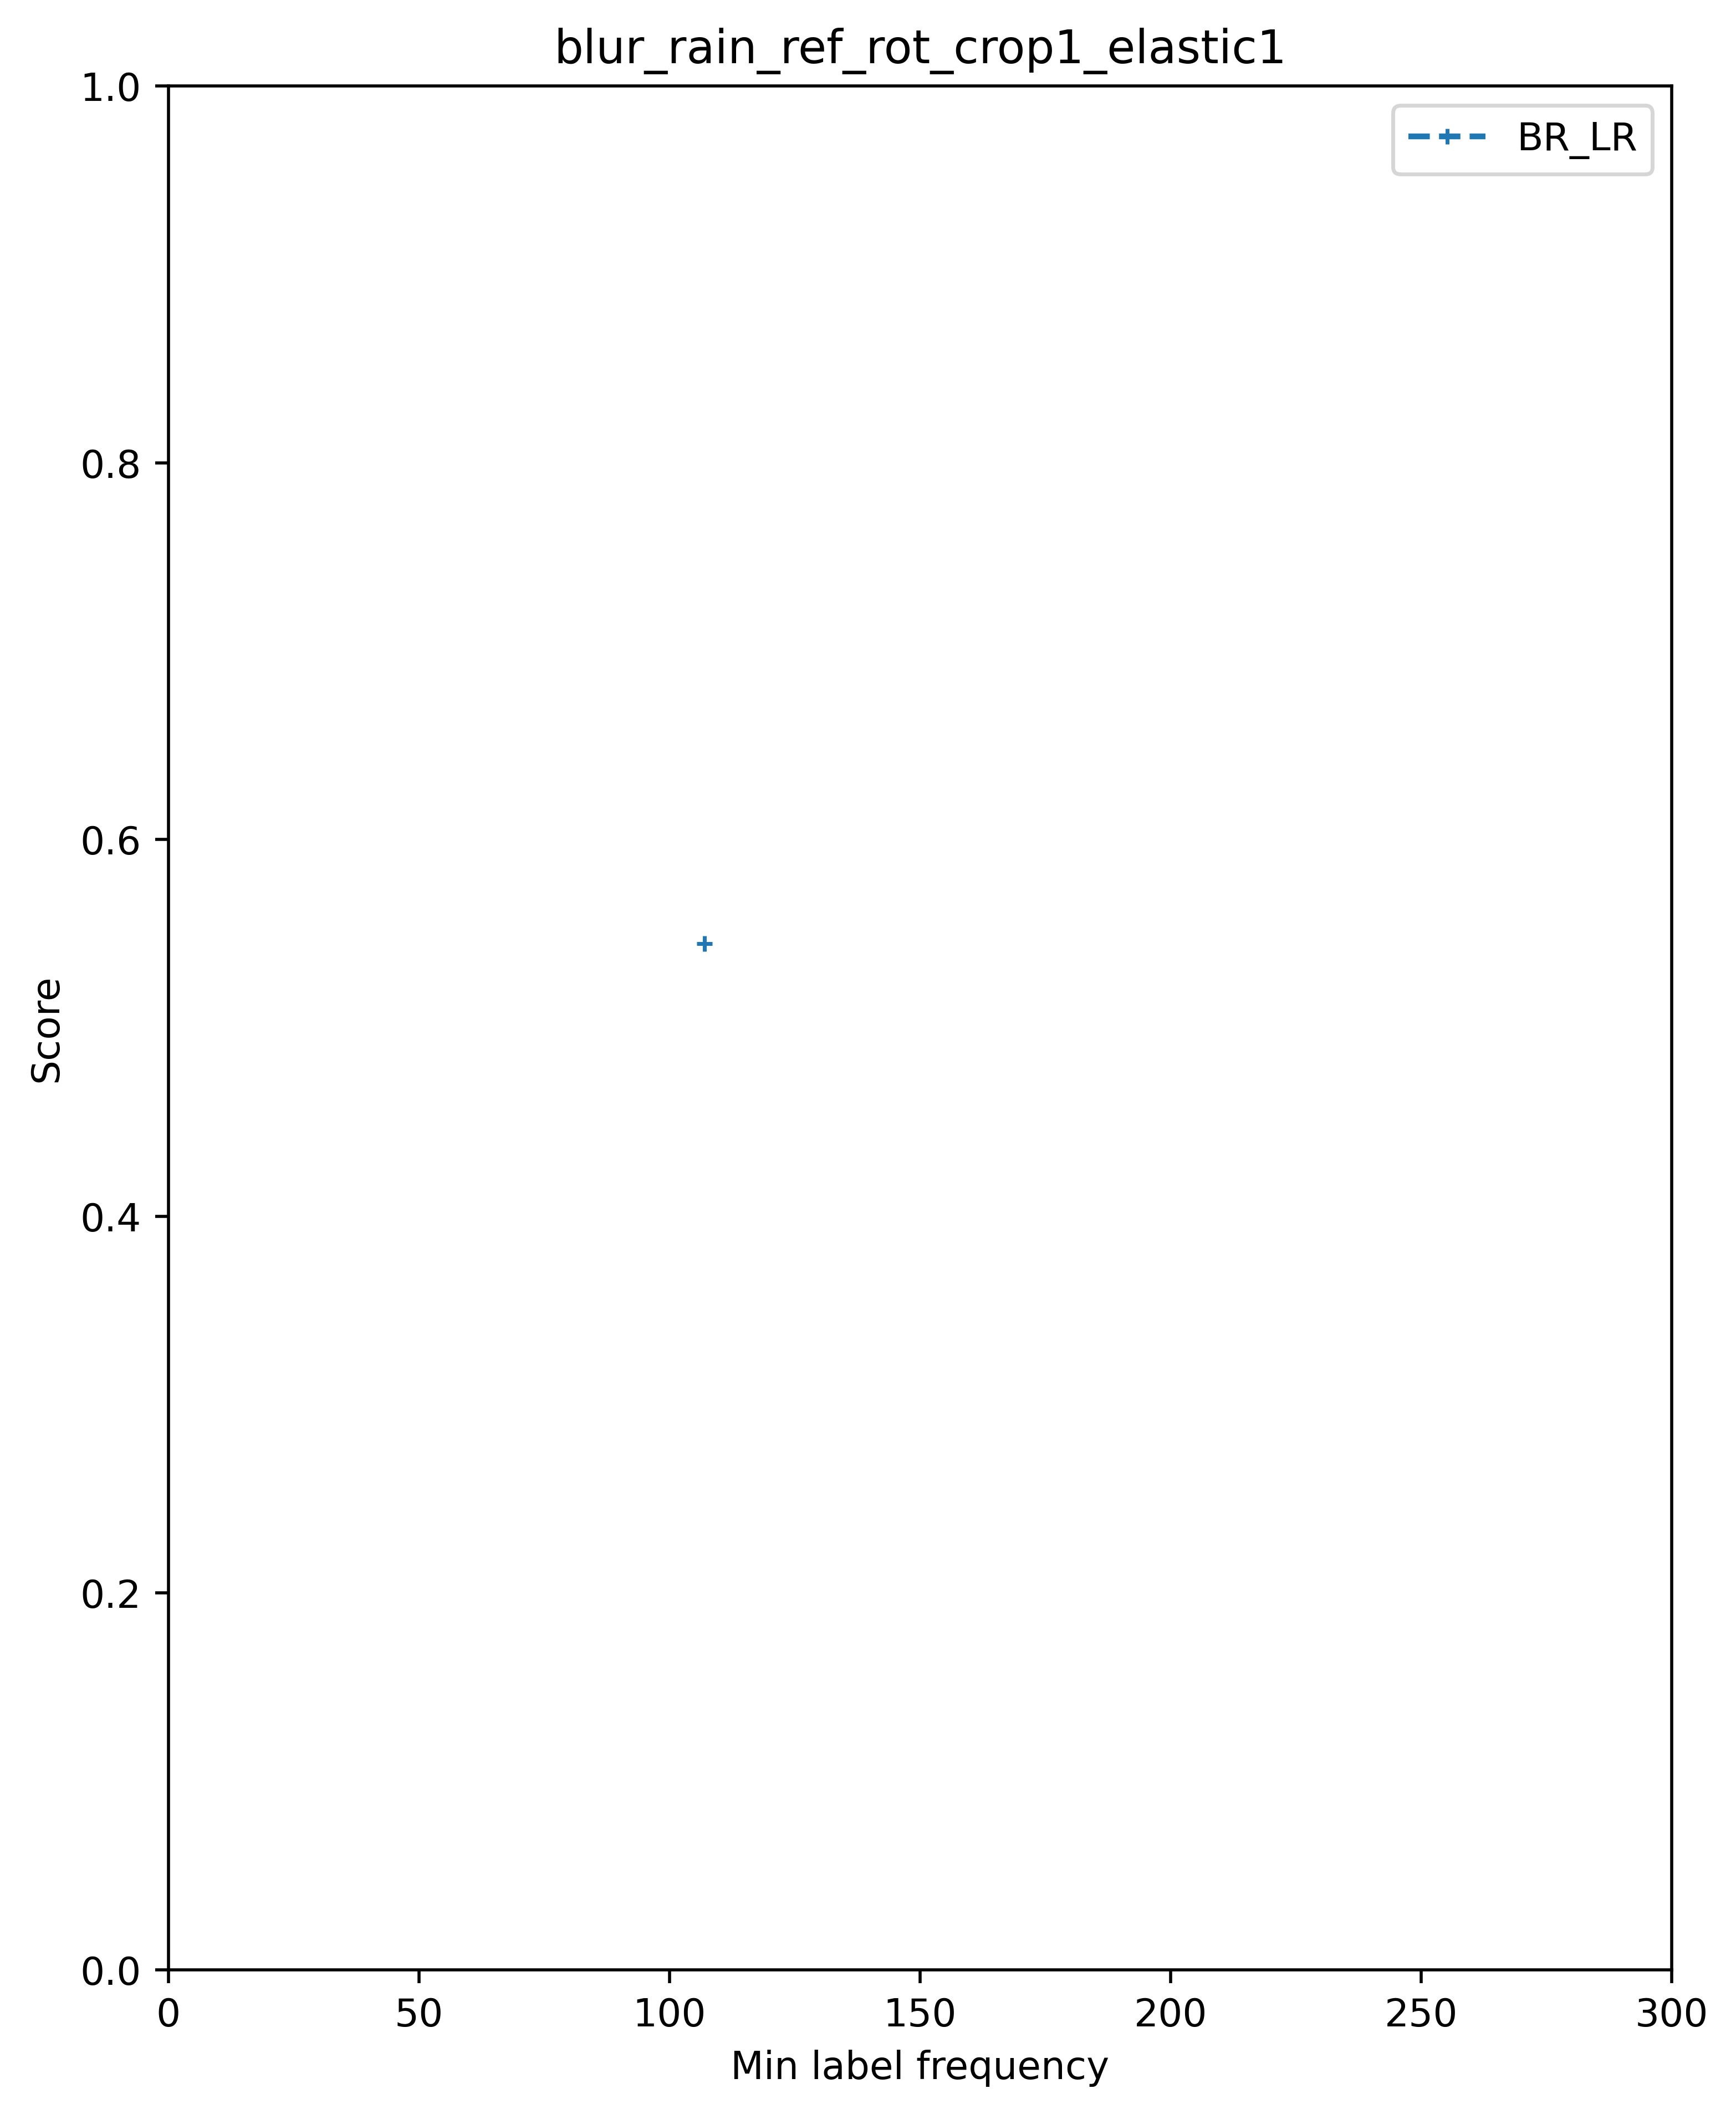

In [107]:
plotter = KunischPlotter()

plotter.plot_results(LABELS_IN_STUDY,
             score = list(exp_f2.values()),
             label = list(exp_f2.keys()),
             title = data_flags,
             ylim  = 1.0,
            xlabel = "Min label frequency", ylabel = "Score")

## Estudio de un modelo particular en un threshold específico

In [109]:
# Selección de modelo y threshold
METHOD = "BR" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "LR" # | "SVC" | "DT" | "GNB" | "LR"
LABELS_IN_STUDY = 281

# Carga de top labels (debe existir previamente)
top_labels = None
print(f"Usando top_labels previamente generados para {LABELS_IN_STUDY} labels")
with open(os.path.join(root_dir, 'labels', f'top_{LABELS_IN_STUDY}L.pickle'), 'rb') as f:
    top_labels = pickle.load(f)
print(f"top labels previamente generado contiene {len(top_labels)} etiquetas")
pruner.set_top_labels(top_labels)

k = 0
fold = Kfolds[k]
features_dir = fold['features_dir']
labels_dir = fold['labels_dir']
features_train = pd.read_json(os.path.join(features_dir, train_filename), orient='index')
features_val = pd.read_json(os.path.join(features_dir, val_filename), orient='index')
features_test = pd.read_json(os.path.join(features_dir, test_filename), orient='index')
labels_train = pd.read_json(os.path.join(labels_dir, train_filename), orient='index')
labels_val = pd.read_json(os.path.join(labels_dir, val_filename), orient='index')
labels_test = pd.read_json(os.path.join(labels_dir, test_filename), orient='index')

# Dataset creation
X_train = features_train.sort_index()
X_test = features_test.sort_index()

Y_train = pruner.filter_df(labels_train) # reduce labels to most freq
Y_test = pruner.filter_df(labels_test) # in both train and test

Y_train = Y_train.sort_index()
Y_test = Y_test.sort_index()

assert X_train.index.all() == Y_train.index.all()
assert X_test.index.all() == Y_test.index.all()

print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

metrics = KunischMetrics(Y_test.values, predictions)

print("F2: {}".format(metrics.f2(average='micro')))
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

Usando top_labels previamente generados para 281 labels
top labels previamente generado contiene 281 etiquetas
ATTENTION: TESTING WITH 281 LABELS
F2: 0.5448
                 precision    recall  f1-score   support

          panel       0.15      1.00      0.26         3
     horizontal       0.00      0.00      0.00         0
       ornament       0.86      0.87      0.86        84
        hatched       0.88      0.75      0.81       102
       vertical       0.00      0.00      0.00         2
        metopal       0.63      0.83      0.72        29
         circle       0.44      0.73      0.55        11
        filling       0.43      1.00      0.60         3
      enclosing       0.48      0.83      0.61        24
        lozenge       0.00      0.00      0.00         0
         double       0.24      0.57      0.33        14
  cross-hatched       0.00      0.00      0.00         1
       triangle       0.54      0.83      0.66        24
     concentric       0.62      0.88      0.

In [111]:
# Ver algunas predicciones aleatorias
assert Y_test.shape == predictions.shape
Y_pred = predictions.todense()
show_predictions(Y_pred, Y_test)

Patron:  77j
Etiquetas reales:  enclosing line ornament star dot circle floor
Etiquetas predichas:  enclosing line ornament cross chevron hatched circle outline windmill floor fan wing midrib

Patron:  77j
Etiquetas reales:  enclosing line ornament star dot circle floor
Etiquetas predichas:  enclosing line ornament cross chevron hatched circle outline windmill floor fan wing midrib

Patron:  77j
Etiquetas reales:  enclosing line ornament star dot circle floor
Etiquetas predichas:  enclosing line ornament cross chevron hatched circle outline windmill floor fan wing midrib

Patron:  77j
Etiquetas reales:  enclosing line ornament star dot circle floor
Etiquetas predichas:  enclosing line ornament cross chevron hatched circle outline windmill floor fan wing midrib

Patron:  77j
Etiquetas reales:  enclosing line ornament star dot circle floor
Etiquetas predichas:  enclosing line ornament cross chevron hatched circle outline windmill floor fan wing midrib

Patron:  77j
Etiquetas reales:  enc

In [112]:
# Ver matrices de confusión
ncols = 7
nrows = 281 // ncols + 1
figsize = (2*ncols, 2*nrows)
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 500
plotter.plot_multiple_matrix(cfs_matrix, present_labels, nrows=nrows, ncols=ncols, figsize=figsize, normalize=True)